# YouTube Daily Trending Videos Analysis

**Objective:**  
Analyze daily trending YouTube videos to understand engagement patterns, upload timing, and trending duration using engineered engagement metrics.


## Dataset Description

- Source: Kaggle (Daily Trending Videos)
- Each row represents a video on a specific trending date
- Videos repeat if they trend on multiple days or countries
- Large, real-world dataset suitable for analytics


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns


In [3]:
df = pd.read_csv('daily_trending_videos.csv')
df.head()

,video_id,title,channel,country,views,likes,comments,published_at,fetch_date
0,KDorKy-13ak,Kendrick Lamar's Apple Music Super Bowl Halfti...,NFL,US,33079510,1633864,98574,2025-02-10T03:22:55Z,2025-02-11 17:43:34
1,lI4dq7ffQy0,Kendrick Lamar Disses Drake During Halftime Sh...,E! News,US,1475936,12629,5126,2025-02-10T03:27:44Z,2025-02-11 17:43:34
2,Y5vgBxUuNlc,JAZZ at LAKERS | FULL GAME HIGHLIGHTS | Februa...,NBA,US,1841263,31666,2906,2025-02-11T06:12:20Z,2025-02-11 17:43:34
3,hUUszE29jS0,Marvel Studios’ Thunderbolts* | Big Game Trail...,Marvel Entertainment,US,9893431,204063,13864,2025-02-09T23:54:00Z,2025-02-11 17:43:34
4,jdX5xwV829s,The First Kiss in Brawl Stars!?,Brawl Stars,US,8354717,257108,17632,2025-02-10T08:58:00Z,2025-02-11 17:43:34


In [4]:
df.tail()

,video_id,title,channel,country,views,likes,comments,published_at,fetch_date
674136,pe_ejTiIcSs,"Lose 100 LBs, Win $250,000!",MrBeast,ZA,159946900,5733735,95304,2025-06-21T16:00:01Z,2025-07-06 11:10:19
674137,oTJrhuNY6cA,Everybody has Secrets 🤫…,Speed McQueen,ZA,8600595,329179,1500,2025-06-29T19:43:42Z,2025-07-06 11:10:19
674138,7oRo-Rmkw2E,Tesla Glue is stronger than you think...,JerryRigEverything,ZA,15126864,691679,13047,2025-06-23T13:17:00Z,2025-07-06 11:10:19
674139,1gib_Cze-sw,British Highschoolers try Texas Brisket for th...,JOLLY,ZA,16368057,1309443,13881,2025-06-25T16:00:02Z,2025-07-06 11:10:19
674140,DeIavYHy3QY,uDlamini yiStar Part 4 - Episode 20 Part 1,MDM Sketch Comedy,ZA,758213,24534,2283,2025-06-18T17:00:06Z,2025-07-06 11:10:19


In [52]:
df.shape

(674141, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 674141 entries, 0 to 674140
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   video_id      674141 non-null  object
 1   title         674141 non-null  object
 2   channel       674141 non-null  object
 3   country       674141 non-null  object
 4   views         674141 non-null  int64 
 5   likes         674141 non-null  int64 
 6   comments      674141 non-null  int64 
 7   published_at  674141 non-null  object
 8   fetch_date    674141 non-null  object
dtypes: int64(3), object(6)
memory usage: 46.3+ MB


In [7]:
df.isnull().sum()

video_id        0
title           0
channel         0
country         0
views           0
likes           0
comments        0
published_at    0
fetch_date      0
dtype: int64

## Descriptive Analysis


In [8]:
# Total records
print("Total records:", len(df))

# Unique videos
print("Unique videos:", df['video_id'].nunique())

# Unique channels
print("Unique channels:", df['channel'].nunique())

# Countries covered
print("Countries covered:", df['country'].nunique())


Total records: 674141
Unique videos: 52219
Unique channels: 16978
Countries covered: 93


In [9]:
df[['views', 'likes', 'comments']].describe()


,views,likes,comments
count,6.741410e+05,6.741410e+05,674141.000000
mean,1.299674e+07,3.782878e+05,5755.019813
std,2.646282e+07,8.148719e+05,22499.916539
min,0.000000e+00,0.000000e+00,0.000000
25%,5.563680e+05,1.615000e+04,451.000000
50%,2.041075e+06,6.687800e+04,1446.000000
75%,1.155525e+07,3.358740e+05,3889.000000
max,3.160123e+08,1.087292e+07,550214.000000


### Initial Observations
- View counts are highly skewed
- A small number of channels dominate trending
- Most videos trend for a short duration


## Feature Engineering & Engagement Metrics


In [17]:
# Work on a copy to avoid warnings
df_fe = df.copy()

# Replace 0 views with NaN for safe division
df_fe['views_safe'] = df_fe['views'].replace(0, np.nan)


In [18]:
df_fe['like_rate'] = df_fe['likes'] / df_fe['views_safe']
df_fe['comment_rate'] = df_fe['comments'] / df_fe['views_safe']
df_fe['view_score'] = df_fe['views'] / df_fe['views'].max()

In [20]:
df_fe['engagement_score'] = (
    0.5 * df_fe['like_rate'] +
    0.3 * df_fe['comment_rate'] +
    0.2 * df_fe['view_score']
)


In [21]:
df_fe[['like_rate', 'comment_rate', 'engagement_score']] = (
    df_fe[['like_rate', 'comment_rate', 'engagement_score']]
    .fillna(0)
)


In [22]:
high_thr = df_fe['engagement_score'].quantile(0.75)
low_thr = df_fe['engagement_score'].quantile(0.25)

def performance_label(score):
    if score >= high_thr:
        return "High Performance"
    elif score <= low_thr:
        return "Low Performance"
    else:
        return "Average Performance"

df_fe['performance_level'] = df_fe['engagement_score'].apply(performance_label)


In [23]:
df_fe[['title', 'views', 'likes', 'comments',
       'like_rate', 'comment_rate',
       'engagement_score', 'performance_level']].head()


,title,views,likes,comments,like_rate,comment_rate,engagement_score,performance_level
0,Kendrick Lamar's Apple Music Super Bowl Halfti...,33079510,1633864,98574,0.049392,0.002980,0.046526,High Performance
1,Kendrick Lamar Disses Drake During Halftime Sh...,1475936,12629,5126,0.008557,0.003473,0.006254,Low Performance
2,JAZZ at LAKERS | FULL GAME HIGHLIGHTS | Februa...,1841263,31666,2906,0.017198,0.001578,0.010238,Low Performance
3,Marvel Studios’ Thunderbolts* | Big Game Trail...,9893431,204063,13864,0.020626,0.001401,0.016995,Average Performance
4,The First Kiss in Brawl Stars!?,8354717,257108,17632,0.030774,0.002110,0.021308,Average Performance


## Time-Based Analysis


In [24]:
df_time = df_fe.copy()

df_time['published_at'] = pd.to_datetime(df_time['published_at'], errors='coerce')
df_time['fetch_date'] = pd.to_datetime(df_time['fetch_date'], errors='coerce')


In [25]:
df_time['publish_day'] = df_time['published_at'].dt.day_name()
df_time['publish_hour'] = df_time['published_at'].dt.hour


In [56]:
trending_days = (
    df_time.groupby('video_id')['fetch_date']
    .nunique()
    .rename('trending_days')
    .reset_index()
)

df_time = df_time.merge(trending_days, on='video_id', how='left')


## Final Visualizations


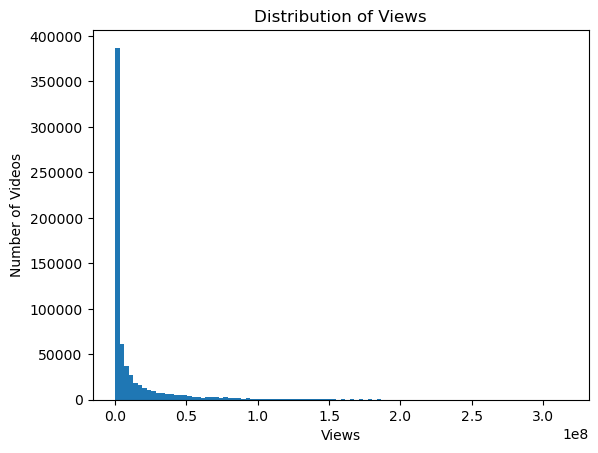

In [58]:
plt.figure()
plt.hist(df_time['views'], bins=100)
plt.xlabel("Views")
plt.ylabel("Number of Videos")
plt.title("Distribution of Views")
plt.show()


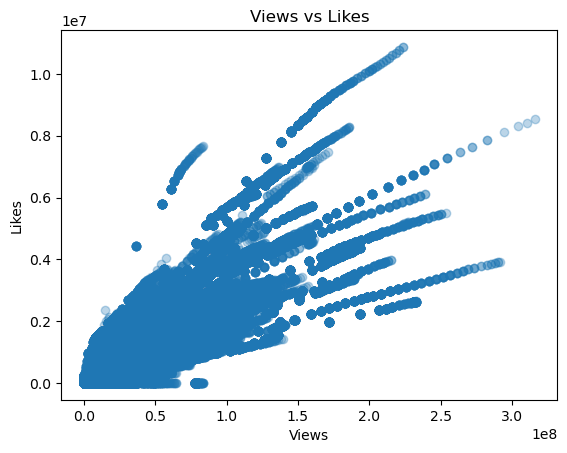

In [59]:
plt.figure()
plt.scatter(df_time['views'], df_time['likes'], alpha=0.3)
plt.xlabel("Views")
plt.ylabel("Likes")
plt.title("Views vs Likes")
plt.show()



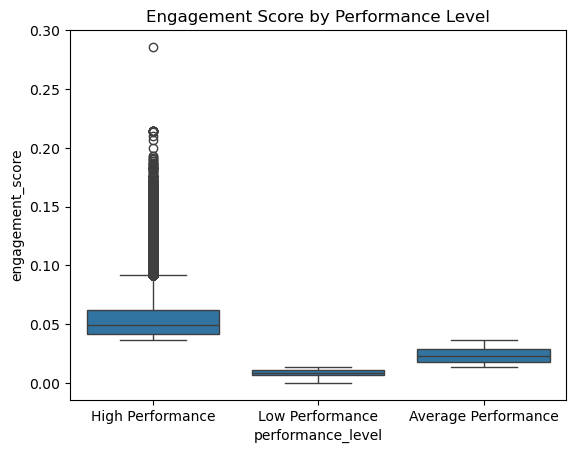

In [60]:
plt.figure()
sns.boxplot(x='performance_level', y='engagement_score', data=df_time)
plt.title("Engagement Score by Performance Level")
plt.show()


C:\Users\Diksham Jindal\AppData\Local\Temp\ipykernel_32708\2803024542.py:13: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Diksham Jindal\AppData\Local\Temp\ipykernel_32708\2803024542.py:13: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Diksham Jindal\AppData\Local\Temp\ipykernel_32708\2803024542.py:13: UserWarning: Glyph 50864 (\N{HANGUL SYLLABLE U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Diksham Jindal\AppData\Local\Temp\ipykernel_32708\2803024542.py:13: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Diksham Jindal\AppData\Local\Temp\ipykernel_32708\2803024542.py:13: UserWarning: Glyph 44216 (\N{HANGUL SYLLABLE GYEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

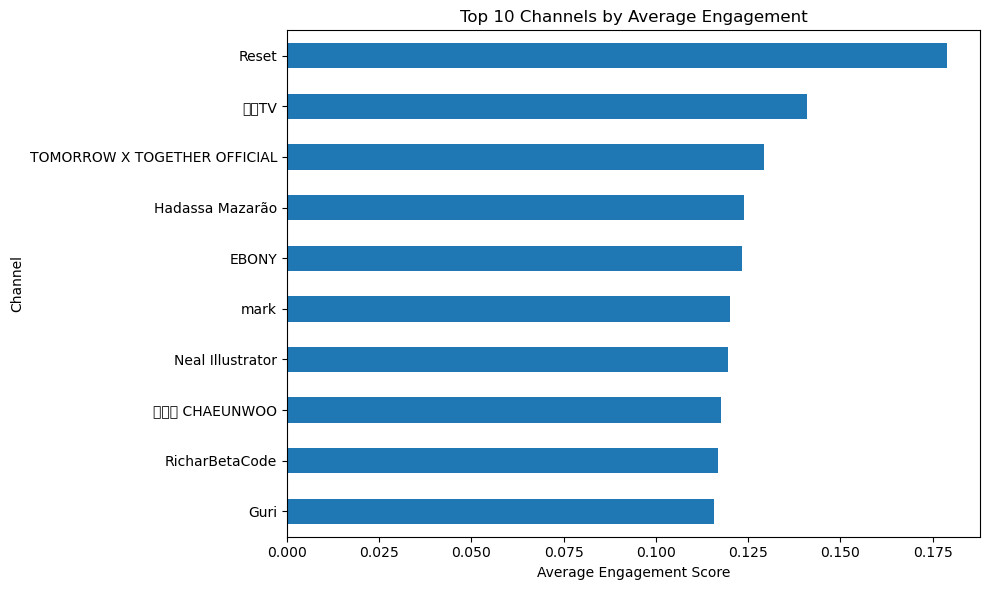

In [61]:
top_channels = (
    df_time.groupby('channel')['engagement_score']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
top_channels.sort_values().plot(kind='barh')
plt.xlabel("Average Engagement Score")
plt.ylabel("Channel")
plt.title("Top 10 Channels by Average Engagement")
plt.tight_layout()
plt.show()


## Key Insights

- Engagement score is more informative than views alone
- Upload timing affects engagement
- Most videos trend briefly; few sustain attention
- Some channels consistently achieve high engagement


## Conclusion

This project analyzed global YouTube daily trending data using feature engineering,
engagement scoring, and time-based analysis. The findings highlight how engagement
metrics, upload timing, and trending duration influence video performance.
